In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd


# Standard imports
import pandas as pd
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy
import sys
import os

# Apply better style
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

%config InlineBackend.figure_format='svg'




In [6]:
df_sim = pd.read_parquet("/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/gen_3/gen_4/gen_5/output_particles.parquet")
df_particle = pd.read_parquet("/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/particles/00.parquet")
df_sim = pd.merge(df_sim, df_particle, on=["particle_id"])

In [7]:
df_sim = df_sim[['at_turn', 'state', 'particle_id', 'normalized amplitude in xy-plane', 'angle in xy-plane [deg]']]

In [8]:
df_sim[df_sim['state'] != 1]

,at_turn,state,particle_id,normalized amplitude in xy-plane,angle in xy-plane [deg]
481,172916,-1,260,6.56250,45.0
482,167425,-1,187,7.31250,30.0
483,155314,-1,283,7.28125,45.0
484,128297,-1,289,7.46875,45.0


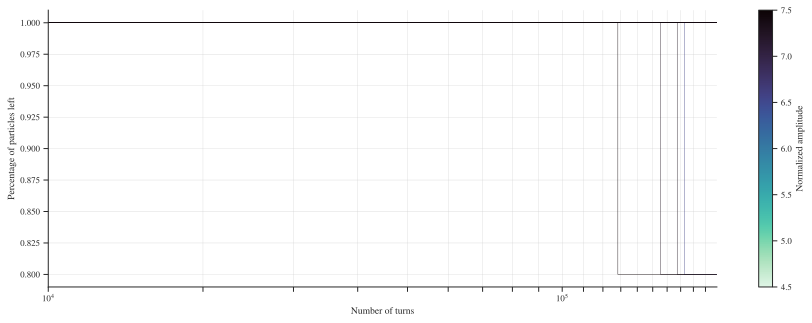

In [9]:
n_turns = df_sim["at_turn"].max()

# Make a colormap for amplitudes
# cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)#plt.get_cmap('viridis')
# colors = [cmap(i) for i in np.linspace(0, 1, len(df_sim["normalized amplitude in xy-plane"].unique()))]

norm = plt.Normalize(
    df_sim["normalized amplitude in xy-plane"].min(),
    df_sim["normalized amplitude in xy-plane"].max(),
)
sm = plt.cm.ScalarMappable(cmap="mako_r", norm=norm)
sm.set_array([])


# Make the plot wide
fig, ax = plt.subplots(figsize=(15, 5))

for i, amplitude in enumerate(df_sim["normalized amplitude in xy-plane"].unique()):
    df_per_amplitude = df_sim[df_sim["normalized amplitude in xy-plane"] == amplitude][
        ["at_turn", "normalized amplitude in xy-plane"]
    ]
    # sort by at_turn
    df_per_amplitude = df_per_amplitude.sort_values(by=["at_turn"])
    # get the percentage of particles left
    l_survived = [len(df_per_amplitude)]
    l_n_turns = [1]
    for idx, row in df_per_amplitude.iterrows():
        if row["at_turn"] == n_turns:
            l_survived.append(l_survived[-1])
            l_n_turns.append(n_turns)
        else:
            # To prevent linearization
            l_survived.append(l_survived[-1])
            l_n_turns.append(row["at_turn"] - 1)
            l_survived.append(l_survived[-1] - 1)
            l_n_turns.append(row["at_turn"])

    plt.plot(
        l_n_turns,
        np.array(l_survived) / len(df_per_amplitude),
        label=f"amplitude = {amplitude}",
        color=sm.to_rgba(amplitude),
        alpha=0.8,
    )

import matplotlib.ticker as ticker


def func(x, pos):
    if x == 0:
        return "0"
    else:
        if np.log10(x) % 1 == 0 or np.log10(x) % 1 == 0.5:
            return r"$10^{{{:.0f}}}$".format(np.log10(x))
        else:
            return ""


plt.xlabel("Number of turns")
plt.ylabel("Percentage of particles left")
ax.set_xscale("log")
plt.xlim(10**4, n_turns)
# plt.semilogx(base=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
# ax.xaxis.set_major_locator(ticker.LogLocator(subs = 'all'))

ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func))

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Normalized amplitude")
# cbar.set_alpha(0.8)
# cbar.draw_all()
plt.grid()
plt.savefig("surviving_particles.pdf")
plt.show()